In [2]:
from tensorflow.keras.applications import ResNet50

from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import torch
from custom_transformers import *
import tensorflow as tf
import matplotlib.pyplot as plt
from augmented_generator import *

## Load data

In [3]:
cifar10 = tf.keras.datasets.cifar10

(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
print(f"X_train.shape: {X_train.shape} \nY_train.shape: {Y_train.shape} \nX_test.shape: {X_test.shape} \nY_test.shape: {Y_test.shape}")

X_train.shape: (50000, 32, 32, 3) 
Y_train.shape: (50000, 1) 
X_test.shape: (10000, 32, 32, 3) 
Y_test.shape: (10000, 1)


## Test Data Generator (with fraction 70% to visualize results)

In [4]:
random_pixel_cutout = RandomPixelCutout(max_cutout_size=0.3, color=False)
generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=8, augmentor=random_pixel_cutout, augment_fraction=0.7)

batch_x, batch_y = generator[0]

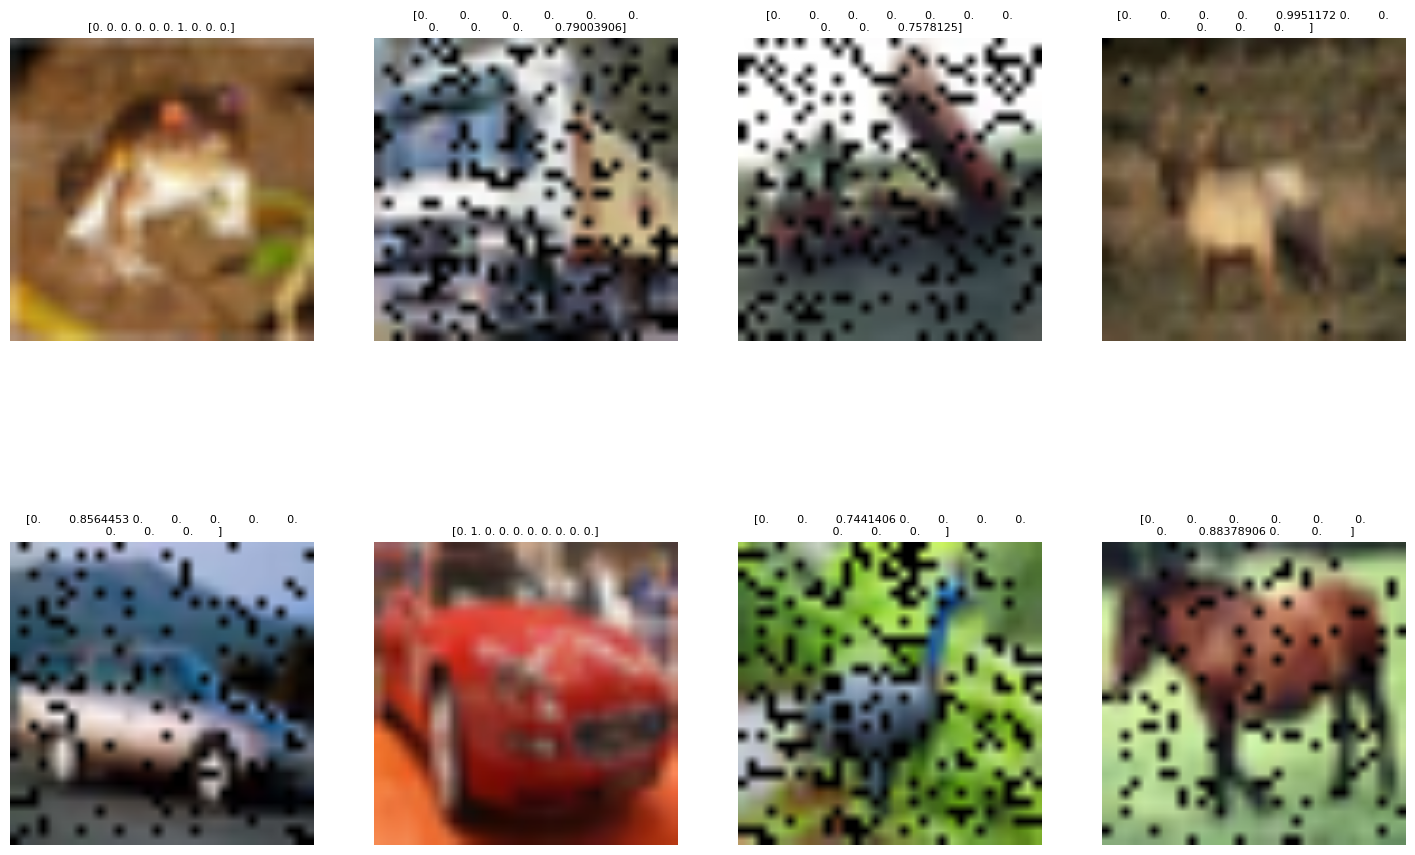

In [5]:
#function to denormalize Restnet preprocessing for visualization purposes
def denormalize_resnet(x):
    x = x.copy()
    x[..., 0] += 103.939  # Blue
    x[..., 1] += 116.779  # Green
    x[..., 2] += 123.68   # Red
    # Zamiana BGR -> RGB
    x = x[..., ::-1]
    x = np.clip(x / 255.0, 0, 1)
    return x

n = len(batch_x)
cols = 4
rows = n//cols + int(n%cols != 0)

fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
if rows == 1 or cols == 1:
    axes = np.expand_dims(axes, axis=0)
for i in range(len(batch_x)):
    row = i // cols
    col = i % cols
    ax = axes[row, col]
    ax.imshow(denormalize_resnet(batch_x[i]))
    ax.set_title(batch_y[i], fontsize=8)
    ax.axis('off')

As we can see some of the images are augmented with soft labels and some have their original labels but with one hot encoding

## Restnet - Random Pixels

In [6]:

random_pixel_cutout = RandomPixelCutout(0.2, color=False)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Create generators
train_gen = AugmentedCIFAR10Generator(
    X_train, 
    Y_train,  
    batch_size=32,
    augmentor=random_pixel_cutout, 
    augment_fraction=0.2
)

test_gen = AugmentedCIFAR10Generator(
    X_test, 
    Y_test,
    batch_size=32,
    shuffle=False,  # No augmentation for test set
    augmentor=None
)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Works with both one-hot and soft labels
    metrics=['accuracy']
)

history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=5
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step
Epoch 1/5


c:\Users\rogal\anaconda3\envs\myenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 296/1563 ━━━━━━━━━━━━━━━━━━━━ 26:22 1s/step - accuracy: 0.5759 - loss: 1.3178

KeyboardInterrupt: 